# Loading SCATSAR soil water index (SWI)

This example is about loading time series data from the so-called SCATSAR (soil water index) SWI dataset produced by the GEO Department at TU Wien. The (deprecated) dataset consists of daily NetCDF files being located/tiled in the Equi7Grid system. Each file contains encoded SWI data for different temporal lags ("T") and some quality flag layers. 

The first step is to collect all file paths.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
import numpy as np

ds_path = r"D:\data\code\yeoda\2022_08__docs\scatsarswi"
filepaths = glob.glob(os.path.join(ds_path, "*.nc"))
filepaths[:10]

['D:\\data\\code\\yeoda\\2022_08__docs\\scatsarswi\\M20190101_120000--_SWI------_SCATSAR-55VV-_---_C0418_EU500M_E048N012T6.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\scatsarswi\\M20190101_120000--_SWI------_SCATSAR-55VV-_---_C0418_EU500M_E048N018T6.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\scatsarswi\\M20190102_120000--_SWI------_SCATSAR-55VV-_---_C0418_EU500M_E048N012T6.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\scatsarswi\\M20190102_120000--_SWI------_SCATSAR-55VV-_---_C0418_EU500M_E048N018T6.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\scatsarswi\\M20190103_120000--_SWI------_SCATSAR-55VV-_---_C0418_EU500M_E048N012T6.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\scatsarswi\\M20190103_120000--_SWI------_SCATSAR-55VV-_---_C0418_EU500M_E048N018T6.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\scatsarswi\\M20190104_120000--_SWI------_SCATSAR-55VV-_---_C0418_EU500M_E048N012T6.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\scatsarswi\\M20190104_120000--_SWI------_SCATSAR-55VV-_---_C0418

Unfortunately, the NetCDF files do not comply with the latest CF conventions needed for *rioxarray*, which is used to retrieve the geospatial information from a file. Therefore, we need to set the mosaic and its CRS manually, which is a quick job since the exemplary dataset only consists of two tiles.

In [3]:
from geospade.crs import SpatialRef
from geospade.raster import Tile, MosaicGeometry

sref_wkt = 'PROJCS["Azimuthal_Equidistant",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",' \
               'SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],' \
               'UNIT["Degree",0.017453292519943295]],PROJECTION["Azimuthal_Equidistant"],' \
               'PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],' \
               'PARAMETER["central_meridian",24.0],PARAMETER["latitude_of_origin",53.0],UNIT["Meter",1.0]]"'
sref = SpatialRef(sref_wkt)
n_rows, n_cols = 1200, 1200
tiles = [Tile(n_rows, n_cols, sref, geotrans=(48e5, 500, 0, 24e5, 0, -500), name="E048N018T6"),
         Tile(n_rows, n_cols, sref, geotrans=(48e5, 500, 0, 18e5, 0, -500), name="E048N012T6")]
mosaic = MosaicGeometry.from_tile_list(tiles)

As a final preparations step, we specify the appropriate naming convention - in this case there is already an existing one, `SgrtFilename`- and use *xarray* to retrieve information from the files.

In [4]:
from yeoda.datacube import DataCubeReader
from veranda.raster.native.netcdf import NetCdfXrFile
from geopathfinder.naming_conventions.sgrt_naming import SgrtFilename 

dimensions = ['dtime_1', 'tile_name']
dc_reader = DataCubeReader.from_filepaths(filepaths, fn_class=SgrtFilename, dimensions=dimensions,
                                              stack_dimension="dtime_1", tile_dimension="tile_name",
                                              mosaic=mosaic,
                                              file_class=NetCdfXrFile)
dc_reader

DataCubeReader -> NetCdfReader(dtime_1, MosaicGeometry):

                                              filepath   tile_name     dtime_1
0    D:\data\code\yeoda\2022_08__docs\scatsarswi\M2...  E048N012T6  2019-01-01
1    D:\data\code\yeoda\2022_08__docs\scatsarswi\M2...  E048N018T6  2019-01-01
2    D:\data\code\yeoda\2022_08__docs\scatsarswi\M2...  E048N012T6  2019-01-02
3    D:\data\code\yeoda\2022_08__docs\scatsarswi\M2...  E048N018T6  2019-01-02
4    D:\data\code\yeoda\2022_08__docs\scatsarswi\M2...  E048N012T6  2019-01-03
..                                                 ...         ...         ...
725  D:\data\code\yeoda\2022_08__docs\scatsarswi\M2...  E048N018T6  2019-12-29
726  D:\data\code\yeoda\2022_08__docs\scatsarswi\M2...  E048N012T6  2019-12-30
727  D:\data\code\yeoda\2022_08__docs\scatsarswi\M2...  E048N018T6  2019-12-30
728  D:\data\code\yeoda\2022_08__docs\scatsarswi\M2...  E048N012T6  2019-12-31
729  D:\data\code\yeoda\2022_08__docs\scatsarswi\M2...  E048N018T6  2019-

As an example, we can define a bounding box in a different coordinate system to read data from.

<GeoAxesSubplot:>

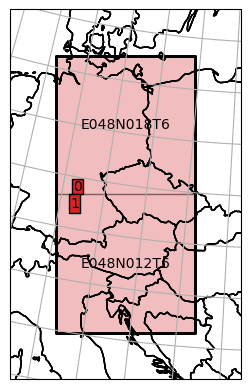

In [5]:
from geospade.crs import SpatialRef
bbox = [(48.64, 10.61), (49.9, 11.1)]
dc_reader.select_bbox(bbox, sref=SpatialRef(4326), inplace=True)

plot_extent = dc_reader.mosaic.parent_root.outer_extent
extent_bfr = 200e3
plot_extent = [plot_extent[0] - extent_bfr, plot_extent[1] - extent_bfr, 
               plot_extent[2] + extent_bfr, plot_extent[3] + extent_bfr]
ax = dc_reader.mosaic.parent_root.plot(label_tiles=True, extent=plot_extent, alpha=0.3)
dc_reader.mosaic.plot(label_tiles=True, ax=ax, extent=plot_extent)

Since the NetCDF files lack in CF compliance, we need to manually specify a decoding function, which basically applies all internal decoding attributes and resets the no data value to 254.

In [6]:
import numpy as np

def decoder(dar, scale_factor=1, offset=0, **kwargs):
    dar = dar.where(dar != 254, np.nan)
    dar = dar * scale_factor + offset
    return dar

Finally, we can read data from this bounding box with a set of data variables we are interested in,

In [7]:
data_variables = ["SWI_T002", "SWI_T020", "SWI_T100"]
dc_reader.read(engine='xarray', data_variables=data_variables, decoder=decoder, parallel=False)

replace no data values,

In [8]:
dc_reader.apply_nan()
dc_reader.data_view

<xarray.Dataset>
Dimensions:      (x: 121, y: 291, time: 365)
Coordinates:
  * x            (x) float64 4.855e+06 4.855e+06 ... 4.914e+06 4.915e+06
  * y            (y) float64 1.865e+06 1.865e+06 ... 1.721e+06 1.72e+06
  * time         (time) float64 4.346e+04 4.347e+04 ... 4.383e+04 4.383e+04
    spatial_ref  int32 0
Data variables:
    SWI_T002     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    SWI_T020     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    SWI_T100     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

define a point to retrieve a single-location time series from,

In [9]:
poi = 48.7, 10.7
dc_ts = dc_reader.select_xy(*poi, sref=SpatialRef(4326))
dc_ts.data_view

<xarray.Dataset>
Dimensions:      (x: 1, y: 1, time: 365)
Coordinates:
  * x            (x) float64 4.863e+06
  * y            (y) float64 1.732e+06
  * time         (time) float64 4.346e+04 4.347e+04 ... 4.383e+04 4.383e+04
    spatial_ref  int32 0
Data variables:
    SWI_T002     (time, y, x) float64 94.5 92.0 88.5 88.5 ... 89.5 89.5 83.0
    SWI_T020     (time, y, x) float64 85.5 85.5 85.5 85.5 ... 84.5 84.5 84.0
    SWI_T100     (time, y, x) float64 68.0 68.0 68.0 68.0 ... 69.5 69.5 69.5

and plot it. 

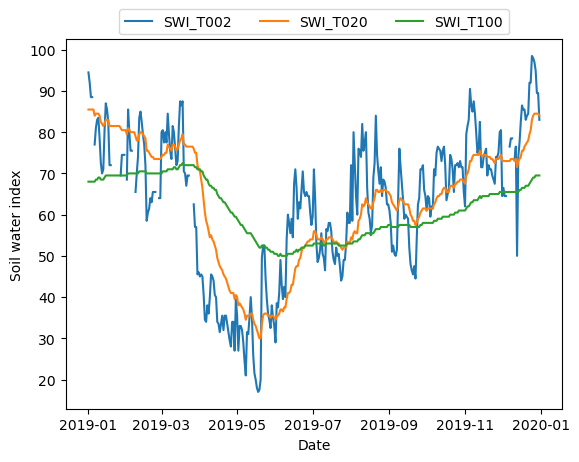

In [10]:
import matplotlib.pyplot as plt

ts = np.unique(dc_reader['dtime_1'])
plt.plot(ts, dc_ts.data_view['SWI_T002'].data.flatten(), label='SWI_T002')
plt.plot(ts, dc_ts.data_view['SWI_T020'].data.flatten(), label='SWI_T020')
plt.plot(ts, dc_ts.data_view['SWI_T100'].data.flatten(), label='SWI_T100')
plt.xlabel('Date')
plt.ylabel('Soil water index')
_ = plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.1))